<a href="https://colab.research.google.com/github/AndreaCorrado00/Emotion-recognition-throught-Deep-Learning-/blob/main/emotions_eeg_lstm_gru_dnn_98_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstract**

This project focus on predicting emotions and finding possible differences between EEG signals of different subjects when they feel the same emotion. To do it, a dataset of EEG signals is evaluated ([here](https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions)) in different settings, firstly to find the best model to predict emotions and then to exploring the possibility of differences between subject-related signals. The dataset includes time-window features and fft points of the raw EEG signal.

The analysis is done using different models: LSTM and GRU DNN on fft signals, FC DNN on time-window features in the first part of the analysis, then for the second part of the analysis, only LSTM is used.

Analysis shows that in order to predict emotions both fft signals and time-window features are good, without great differences between LSTM or GRU modeling, with better performances for the last one set of features. This first result suggest that using time-window features is probably better to classify emotions. Secondly, LSTM network trained on a subject and then tested on the other one reached good performances, suggesting that there aren't strong differences between subjects when they feel the same emotions.

Huge thanks to who build the dataset:

[Researchgate link 1](https://www.researchgate.net/publication/329403546_Mental_Emotional_Sentiment_Classification_with_an_EEG-based_Brain-machine_Interface)

[Researchgate link 2](https://www.researchgate.net/publication/335173767_A_Deep_Evolutionary_Approach_to_Bioinspired_Classifier_Optimisation_for_Brain-Machine_Interaction)


# **1- Packages**

In [47]:
%matplotlib inline

import warnings
import itertools
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from os.path import join
from glob import glob



warnings.filterwarnings('ignore')

In [48]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
  print('no Gpu')

Found 1 GPU


# **2- Data Preparation & EDA**

##**2.1 - EDA and feature analysis**

In [49]:
# Mounthing google drive to access data.
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive"
# Be sure to have a shortcutof the .zip folder in your drive main page.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


Dataset is made like that: on the rows expriments, on the columns features. Variables are for both subject collected in the same line, thus insead of heaving two different acquisition (and in conclusion datasets)  we have a single "continuous" acquistion. so the time "flown" trought the columns.

In [50]:
df = pd.read_csv('emotions.csv')
df.head()
print(df.shape)



(2132, 2549)


----------- NaN check ----------------
No missing values

----------- Balance check ----------------
Classes are balanced
label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64


<Axes: title={'center': 'Label'}, xlabel='label'>

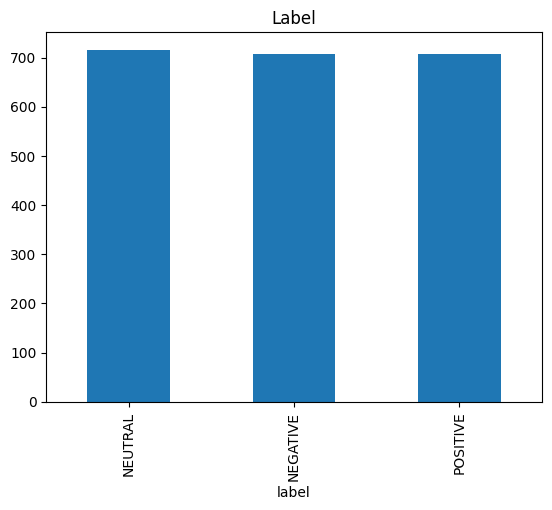

In [51]:
# Checking for missing values
print('----------- NaN check ----------------')
if df.isna().sum().sum()==0:
  print('No missing values')
else:
  print('Missing values in columns:')
  for col in df.columns:
    if(df[col].isnull().sum()>0):
          print(col)
print()
print('----------- Balance check ----------------')


def are_almost_equal(numbers, threshold):
    # Check if absolute differences between all pairs of numbers are within the threshold
    for i in range(len(numbers)):
        for j in range(i+1, len(numbers)):
            if abs(numbers[i] - numbers[j]) > threshold:
                return False
    return True

result=are_almost_equal(df.label.value_counts(),(np.max(df.label.value_counts())-np.min(df.label.value_counts()))+10)

if result:
  print('Classes are balanced')
else:
  print('Classe are unbalanced')

print(df.label.value_counts())
df.label.value_counts().plot(kind='bar', color='tab:blue', title='Label')

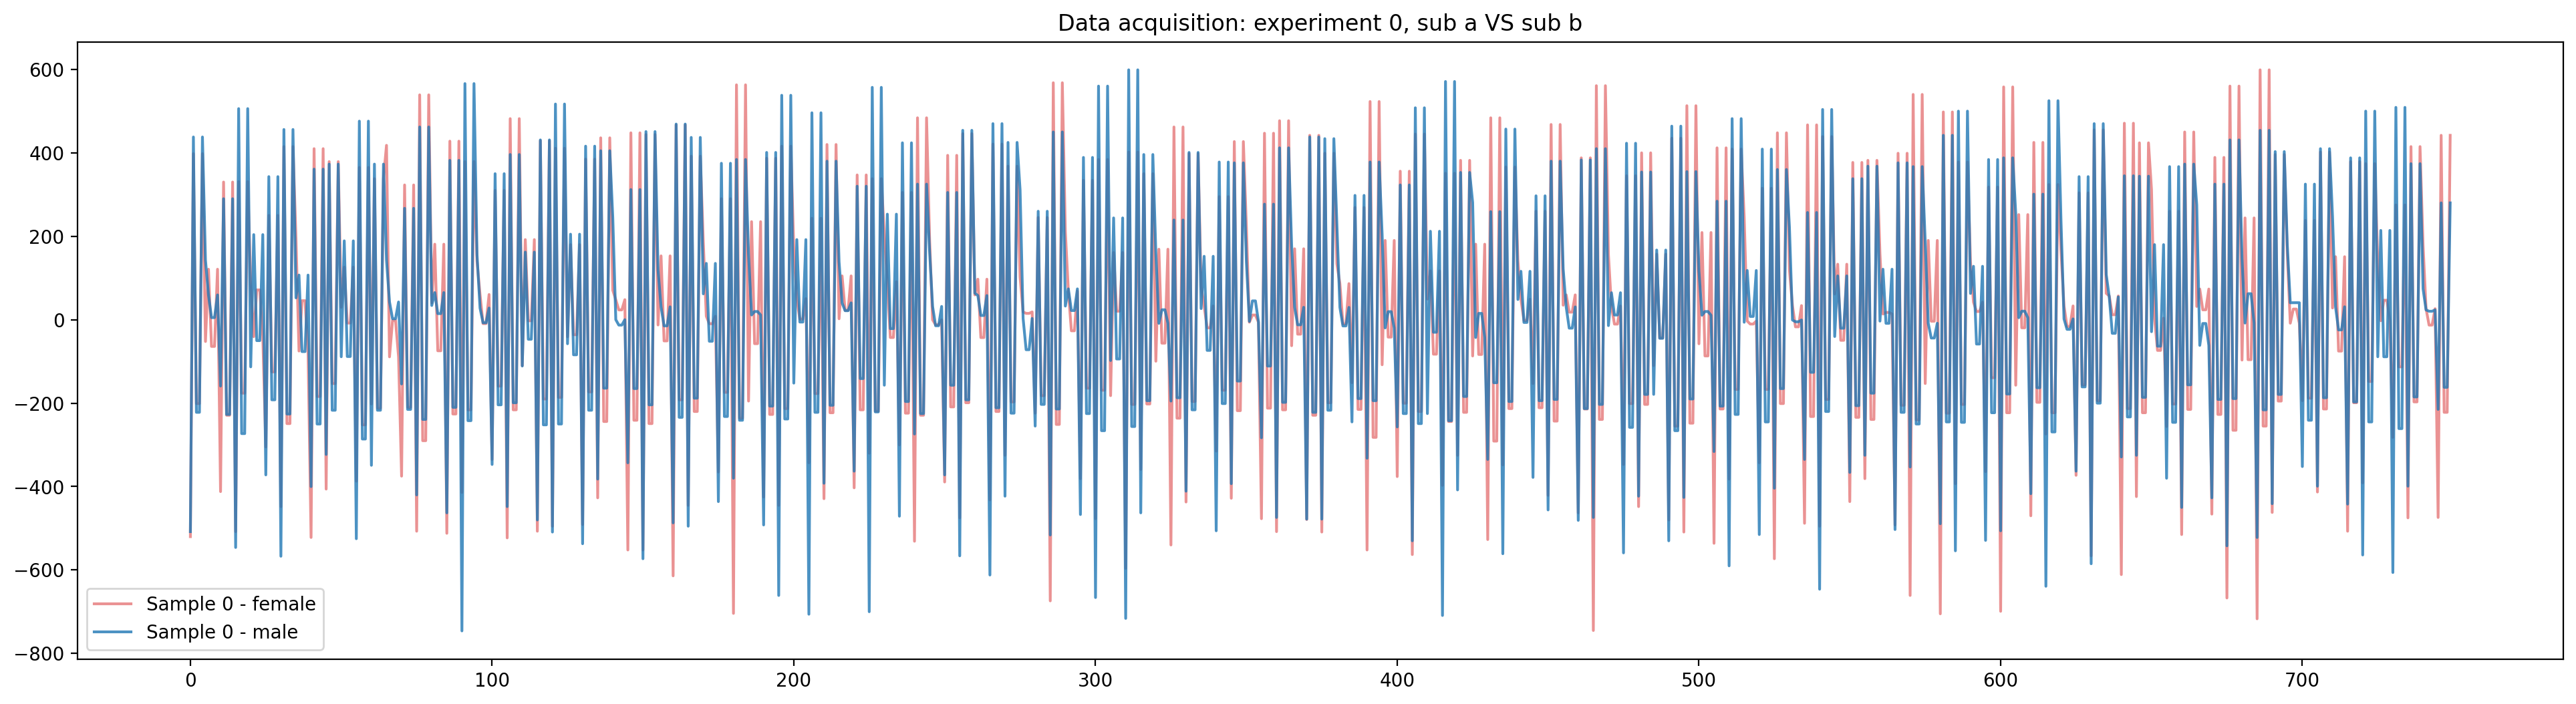

In [52]:
plt.figure(dpi=200, figsize=(24, 6))

index_values = range(len(df.loc[0, 'fft_0_a':'fft_749_a']))
plt.plot(index_values,df.loc[0, 'fft_0_a':'fft_749_a'], label='Sample 0 - female', color='tab:red', alpha=.5)
plt.plot(index_values,df.loc[0, 'fft_0_b':'fft_749_b'], label='Sample 0 - male ', color='tab:blue', alpha=.8)

plt.legend(loc='best')
plt.title('Data acquisition: experiment 0, sub a VS sub b')
plt.show()

# Assumption: subject a is the female, subject b is the male. Just to have an idea.

Text(0.5, 0.98, 'Examples of acquisitions trought experiments')

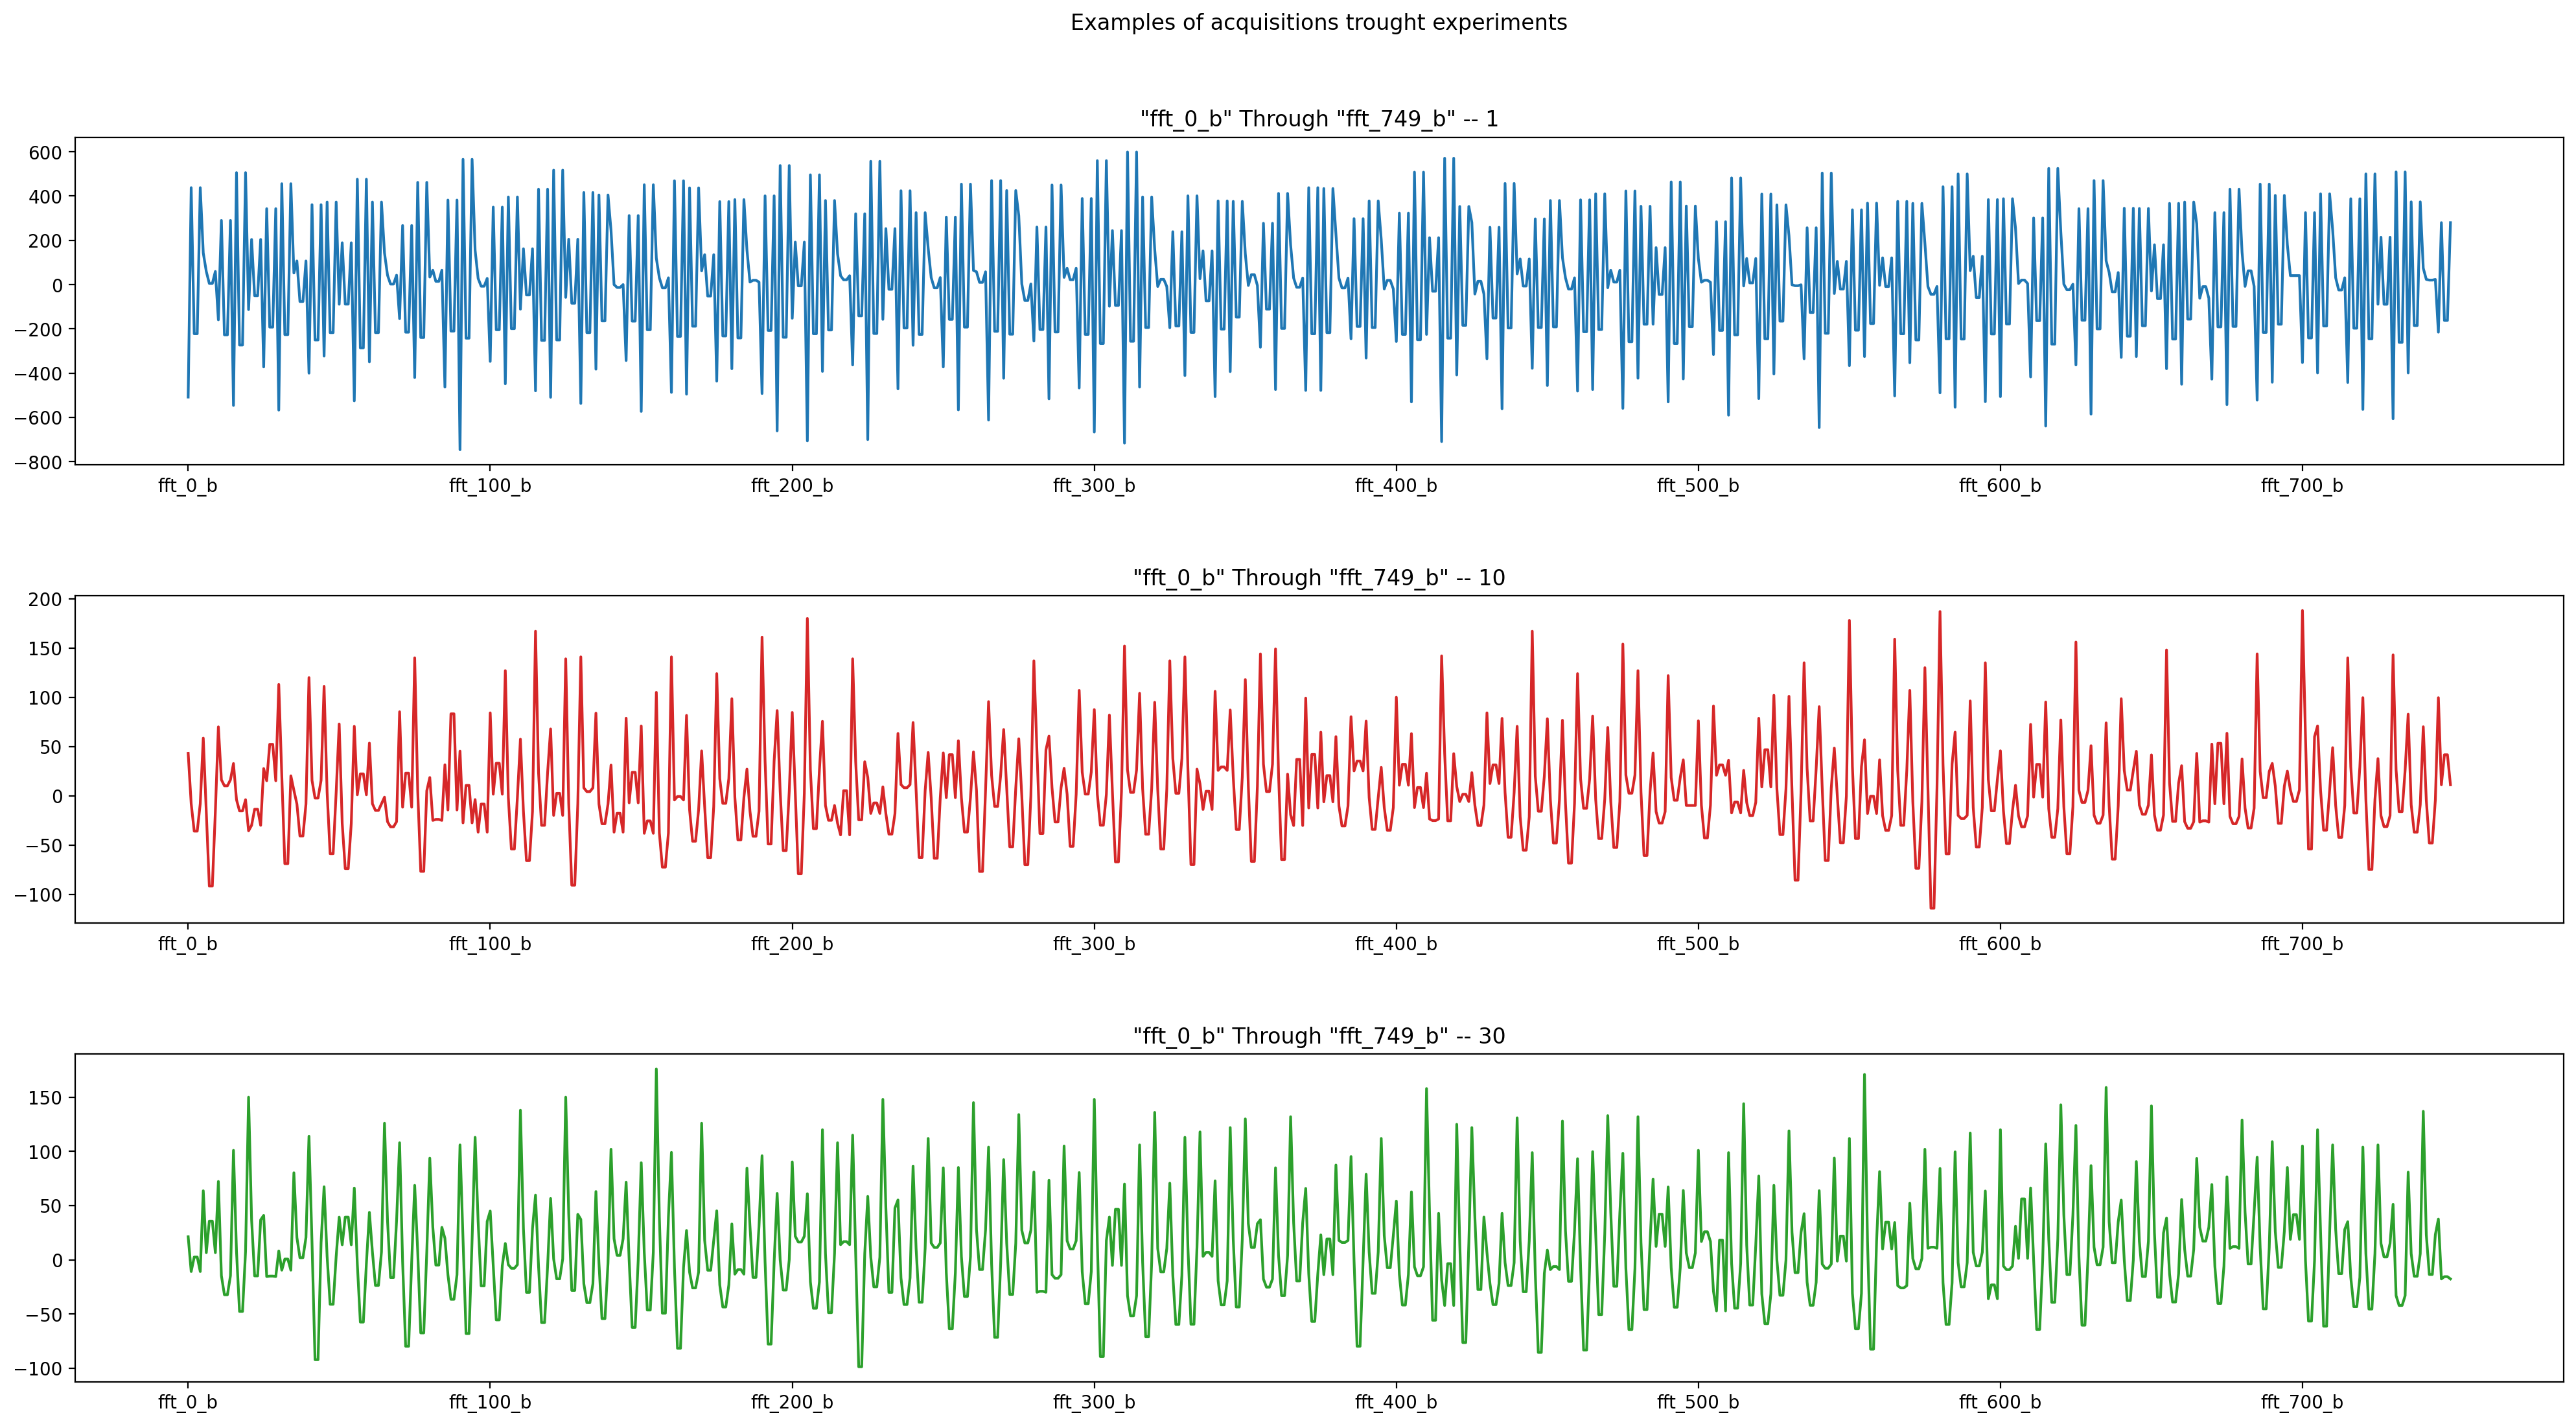

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 12))

df.loc[0, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 1', color='tab:blue', ax=axes[0])
df.loc[10, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 10', color='tab:red', ax=axes[1])
df.loc[30, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 30', color='tab:green', ax=axes[2])

plt.subplots_adjust(left=0.1, bottom=0.1,
                    right=0.9, top=0.9,
                    wspace=0.4, hspace=0.4)
fig.suptitle('Examples of acquisitions trought experiments')


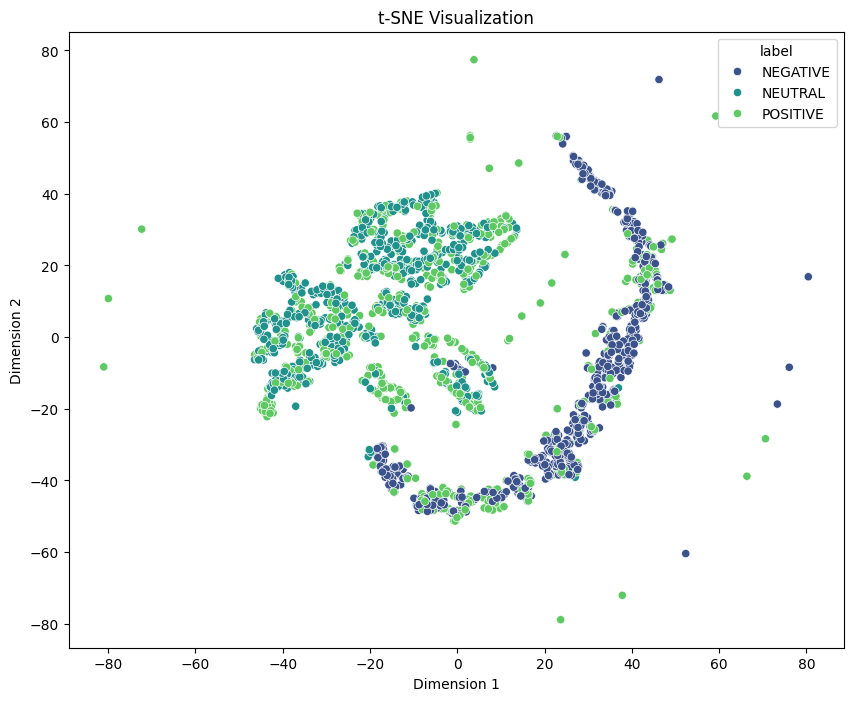

In [54]:
# t-SNE Visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df.drop('label', axis=1))
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['label'] = df['label']
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='label', data=tsne_df, palette='viridis')
plt.title("t-SNE Visualization")
plt.show()

## **2.1 - Data preparation**

In [55]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

# mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_744_b  fft_745_b  fft_746_b  fft_747_b  fft_748_b  fft_749_b  label  
0       23.5     -215.0     280.00    -162.00    -162.00     280.00      0  
1      -23.3      182.0       2.57     -31.60     -31.60       2.57      1  
2      462.0     -267.0     281.00    -148.00    -148.00     281.00      2  
3      299.0      132.0     -12.40       9.53       9.53     -12.40      2  
4       12.0      119.0     -17.60      23.90      23.90     -17.60      1  

[5 rows x 2549 columns]

In [56]:
Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

In [93]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris

print(X.shape)
# mutual information
mi_scores = mutual_info_classif(X, Y)

# Showing results
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

# selecting first 100 most informative features
num_features_to_select = 100
selected_features = mi_df['Feature'][:num_features_to_select]

print("Most 100 informative features:")
print(selected_features)




(2132, 2548)
Most 100 informative features:
1484      covmat_0_b
210       covmat_0_a
1276        mean_2_b
2           mean_2_a
12       mean_d_2_a2
            ...     
1640        logm_0_b
366         logm_0_a
1349     moments_5_b
75       moments_5_a
1356    moments_12_b
Name: Feature, Length: 100, dtype: object


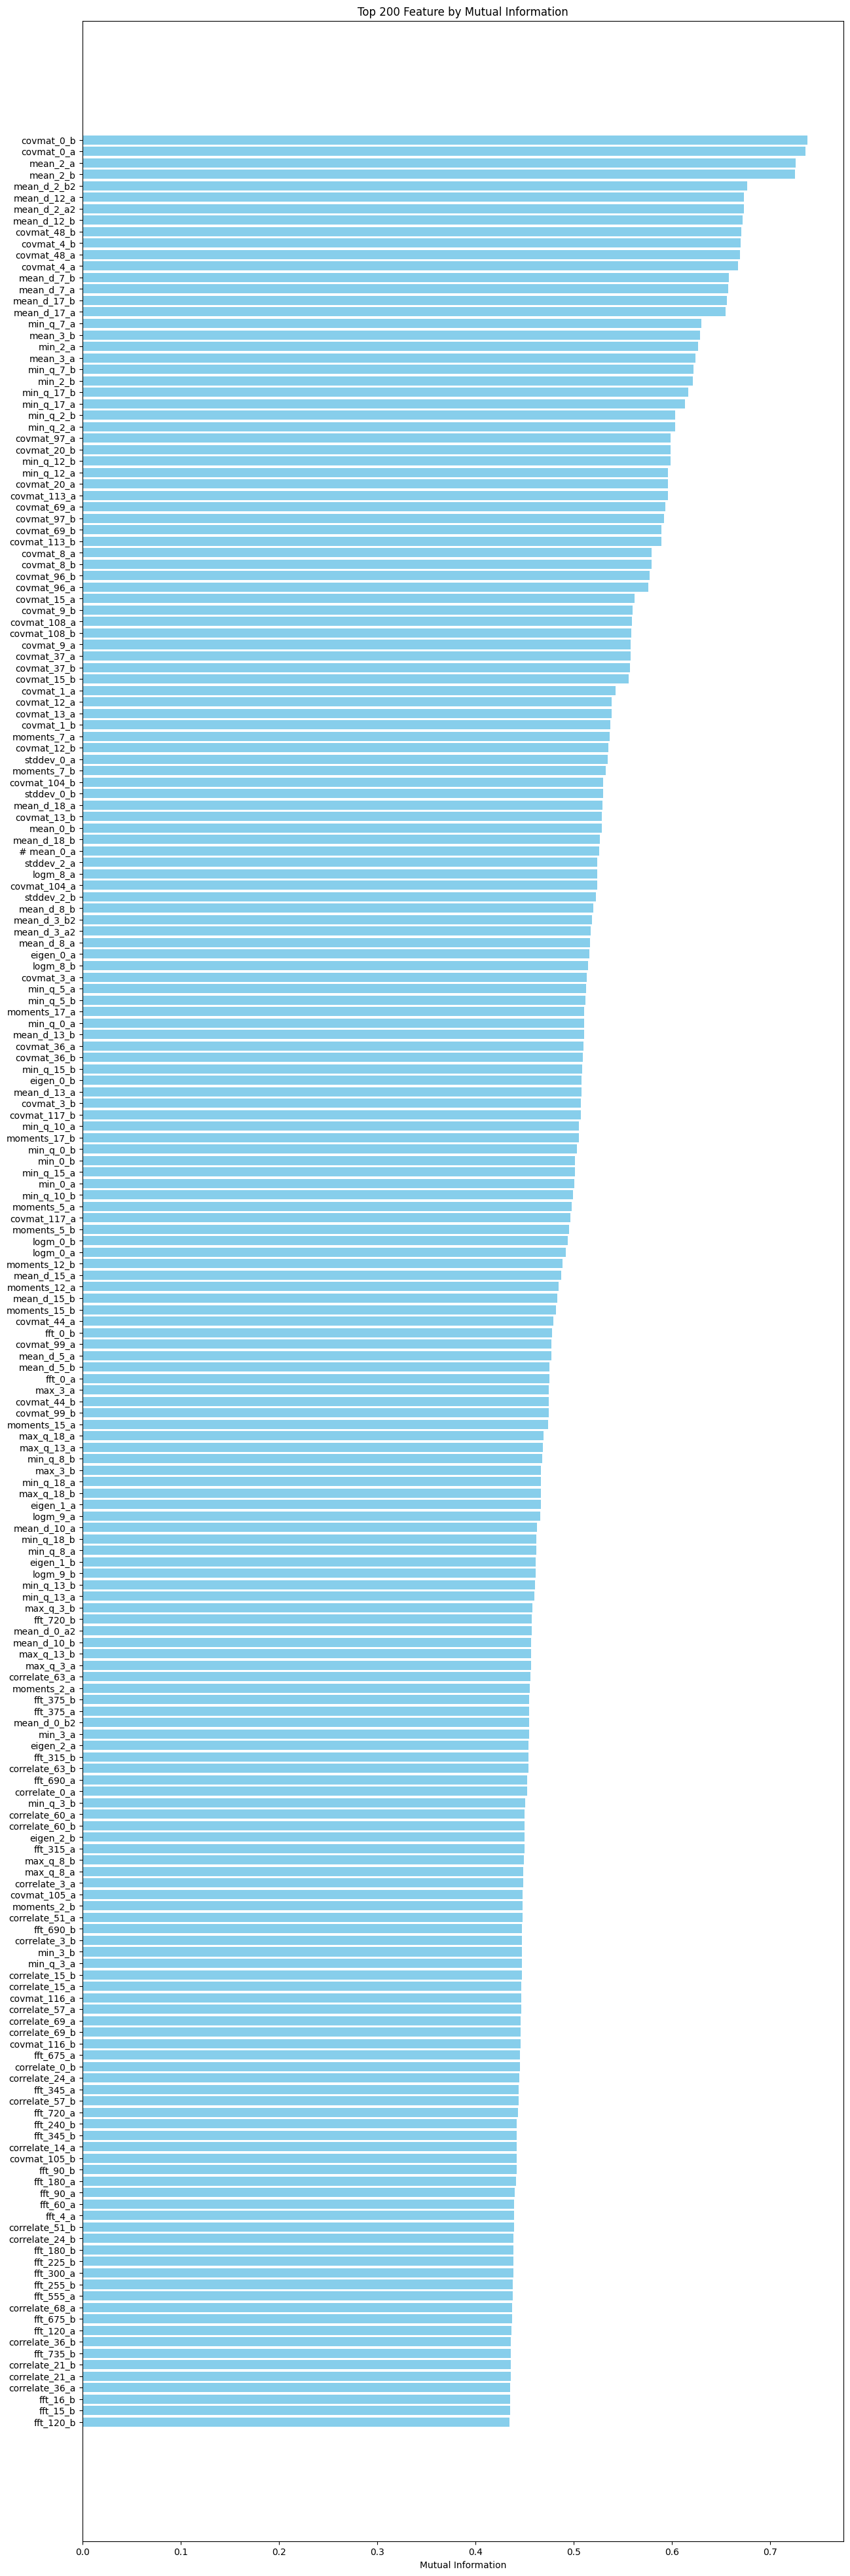

In [58]:

num_features_to_select = 200
top_features = mi_df.iloc[:num_features_to_select]

# Plotting
plt.figure(figsize=(15,50))
plt.barh(top_features['Feature'], top_features['Mutual_Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.title(f'Top {num_features_to_select} Feature by Mutual Information')
plt.gca().invert_yaxis()
plt.show()


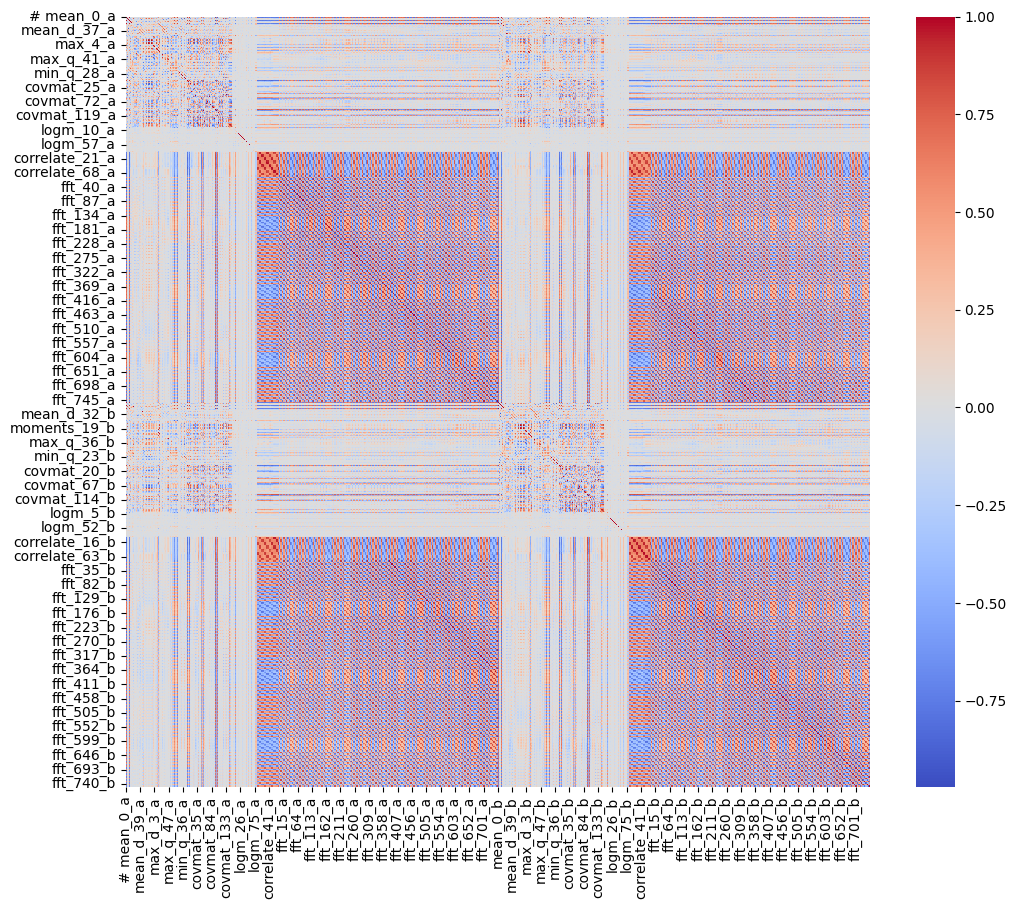

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df.drop('label', axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

*Some comments about EDA*

There are two main aspects about the dataset that surprise me:
1. data are not really collected as time series, instead there are 2 sub-blocks:
    
    a. one related to the varibles collectect in different time frames (means, covariances..., first columns of the dataset)
    
    b. a second one related to the real FFT of the signal

  Only data b) can be actually intepreted as a time series to be used into a RNN as they are. Moreover, looking at MI exploration there aren't variables stronghly more informative than others. In particular, even if some of them seems to carry out an higher MI, the same variables collected from a different time step doesn't appear as informative as the other, suggesting a bit of "confusion".

2. Technically, this scenario can be tretaed in 3 possibile ways:

    a. By considering the daataset as it is: each variable is a sort of descriptor without a real time significance (i.e. my signal has a certain mean in frame 1, a certain value of fft at frequency 0, 100...)

    b. By dividing the dataset into 2 parts, one related to variables (treathed as above), one related to the real time-dependent signal (fft)

    c. By adding a dimension into the dataset, the time, and by rebuilding the dataset in a way such that in position i.e. (1,1) there are all the variables values related to the first time frame.

  Now possibility a) and b) are followed and explored. So 3 dataset will be explored: one with all variables, one with only fft, one with only variables without time.

  Two models frames will be used: one DNN on the whole datset and on the "only variables" subset, RNN on fft data.


In [59]:

def dataset_builder(X,Y,all_dataset=True,only_fft=True,show=True):

  # case 1
  if all_dataset==True and only_fft==False:
      # normalization
    columns_df=X.columns
    X= StandardScaler().fit_transform(X)
    X=pd.DataFrame(X,columns=columns_df)

    print('Whole dataset will be used, option a) choosen \n')
    X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.2)
    X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.2)

  # case 2
  elif all_dataset==False and only_fft==True:
    print('Only fft time series columns are used \n')
    fft_columns=X.columns[X.columns.str.contains('fft')]
    X_fft=X[fft_columns]

    X_train, x_test, Y_train, y_test = train_test_split(X_fft, Y,random_state=111, test_size=0.2)
    X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.2)

  # case 3
  elif all_dataset==False and only_fft==False:
    print('Only time indipendent columns are used \n')
    variables_columns=X.columns[~X.columns.str.contains('fft')]
    X_variables=X[variables_columns]
    #print(X_variables)

    # normalization
    X_variables = StandardScaler().fit_transform(X_variables)
    X_variables=pd.DataFrame(X_variables,columns=X[variables_columns].columns)

    X_train, x_test, Y_train, y_test = train_test_split(X_variables, Y,random_state=111, test_size=0.2)
    X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.2)

  # showing the dataframe
  if show==True:
    print('Train set')
    print(X_train.head())
    print()
    print('Test set')
    print(x_test.head())

  X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
  x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1],1))

  Y_train = pd.get_dummies(Y_train)
  y_test = pd.get_dummies(y_test)
  y_val = pd.get_dummies(y_val)

  return X_train,Y_train,x_test,y_test,x_val,y_val

# **3- Modeling**

The goal here is finding the best model which involves the lowest number of features in the analysis. Here the aim is not finding performances roughly but finding the best structure of the model to proceed in a secon time with the analysis of the groups using the model archtepture found.

Here I define some functions to show the results in a second moment

In [61]:
def metrics_evolution(model, model_type='Deep Neural Network'):
  acc = model.history['accuracy']
  val_acc = model.history['val_accuracy']

  loss = model.history['loss']
  val_loss = model.history['val_loss']


  plt.figure(figsize=(12, 12))

  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy', color='r')
  plt.plot(val_acc, label='Validation Accuracy', color='b')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.legend(loc='lower right', fontsize=13)
  plt.ylabel('Accuracy', fontsize=16, weight='bold')
  plt.title(f'{model_type} - Training & Validation Acc.', fontsize=16, weight='bold')


  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss', color='r')
  plt.plot(val_loss, label='Validation Loss', color='b')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.legend(loc='upper right', fontsize=13)
  plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
  plt.title(f'{model_type} - Training & Validation Loss', fontsize=15, weight='bold')
  plt.xlabel('Epoch', fontsize=15, weight='bold')

  plt.show()

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

In [63]:
def model_performances(model, x_test, y_test,normalized_CM=True, model_type='Deep Neural Network'):

  lstm_best = load_model(model)
  lstm_acc = lstm_best.evaluate(x_test, y_test, verbose=0)[1]
  print('------------------------------------------------------------------')
  print(f'Model performances of model {model_type} saved as {model}:\n')
  print("Test Acc.: {:.3f}%".format(lstm_acc * 100))
  print()
  y_pred = np.array(list(map(lambda x: np.argmax(x), lstm_best.predict(x_test))))
  cm = confusion_matrix(y_test.idxmax(axis=1), y_pred)
  print(classification_report(y_test.idxmax(axis=1), y_pred))

  cnf_matrix = confusion_matrix(y_test.idxmax(axis=1), y_pred)
  np.set_printoptions(precision=2)

  plt.figure(figsize=(10, 10))
  if normalized_CM:
    title=f'{model_type} - Normalized Confusion Matrix'
  else:
    title=f'{model_type} - Confusion Matrix'

  plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'], normalize=normalized_CM,
                        title=title)
  plt.show()

## **3.1 FFT subset**

Both LSTM and GRU framework are used to investigate the best solution to model fft data

### **Model 1: LSTM on fft subset**

In [64]:
X_train,Y_train,x_test,y_test,x_val,y_val=dataset_builder(X,Y,all_dataset=False,only_fft=True,show=False)


Only fft time series columns are used 



In [65]:
def rnn_model(x_train,n_classes,n_recurrent_neurons,model_type='lstm'):
  input_layer = keras.layers.Input(shape=(x_train.shape[1], 1))

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(input_layer)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(input_layer)

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(x)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(x)

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(x)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(x)

  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Flatten()(x)
  y = keras.layers.Dense(n_classes, activation='softmax')(x)

  return keras.models.Model(inputs=input_layer, outputs=y)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1500, 1)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 1500, 256)         264192    
                                                                 
 lstm_4 (LSTM)               (None, 1500, 256)         525312    
                                                                 
 lstm_5 (LSTM)               (None, 1500, 256)         525312    
                                                                 
 dropout_11 (Dropout)        (None, 1500, 256)         0         
                                                                 
 dense_13 (Dense)            (None, 1500, 128)         32896     
                                                                 
 dropout_12 (Dropout)        (None, 1500, 128)         0   

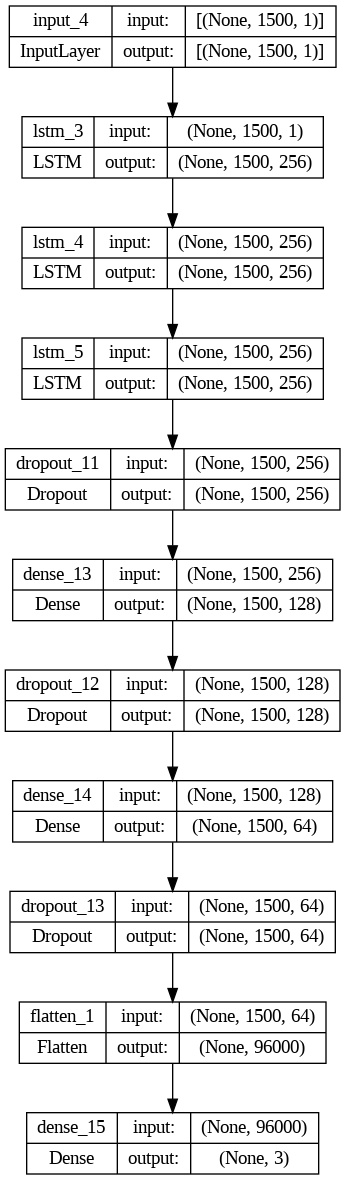

In [66]:
lstm_model = rnn_model(
    x_train=X_train,
    n_classes=3,
    n_recurrent_neurons=256,
    model_type='lstm'
)
print(lstm_model.summary())
keras.utils.plot_model(lstm_model, "lstm.png", show_shapes=True)

In [67]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True,min_delta=0.01)
mc = ModelCheckpoint('./best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

lstm_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

print('fft signal modeling throught LSTM')
lstm_h = lstm_model.fit(X_train, Y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[ es,mc, lr_schedule])

fft signal modeling throught LSTM
Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.7808
Epoch 1: val_accuracy improved from -inf to 0.90029, saving model to ./best_lstm_model.h5
43/43 [==============================] - 20s 309ms/step - loss: 0.5337 - accuracy: 0.7808 - val_loss: 0.3262 - val_accuracy: 0.9003 - lr: 0.0010
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.8944
Epoch 2: val_accuracy improved from 0.90029 to 0.93548, saving model to ./best_lstm_model.h5
43/43 [==============================] - 11s 268ms/step - loss: 0.2418 - accuracy: 0.8944 - val_loss: 0.1737 - val_accuracy: 0.9355 - lr: 9.0484e-04
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9216
Epoch 3: val_accuracy improved from 0.93548 to 0.94428, saving model to ./best_lstm_model.h5
43/43 [==============================] - 11s 264ms/step - loss: 0.2055 - accuracy: 0.9216 - val_loss: 0.2245 - val

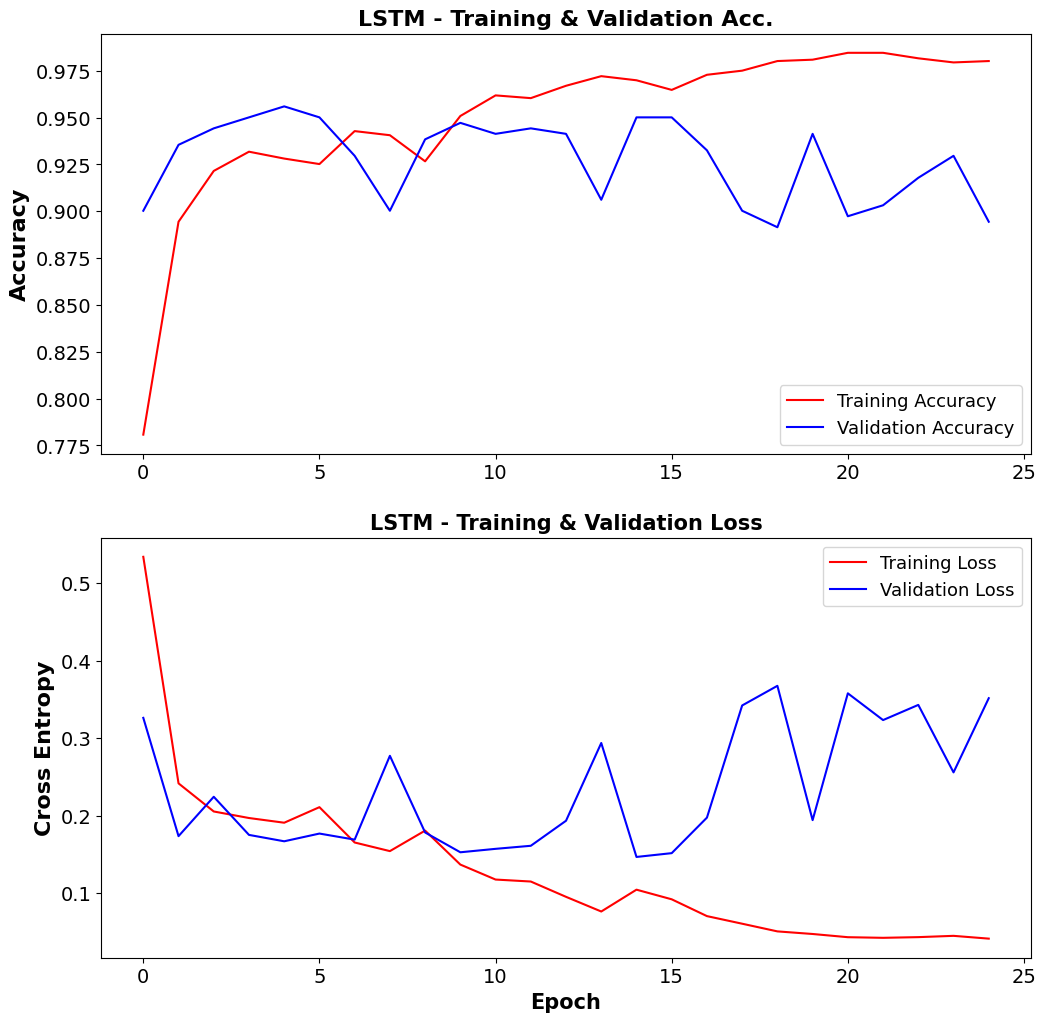

------------------------------------------------------------------
Model performances of model LSTM saved as ./best_lstm_model.h5:

Test Acc.: 92.272%

14/14 [==============================] - 3s 97ms/step
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       115
           1       1.00      1.00      1.00       164
           2       0.93      0.84      0.88       148

    accuracy                           0.92       427
   macro avg       0.92      0.92      0.92       427
weighted avg       0.93      0.92      0.92       427

Normalized confusion matrix


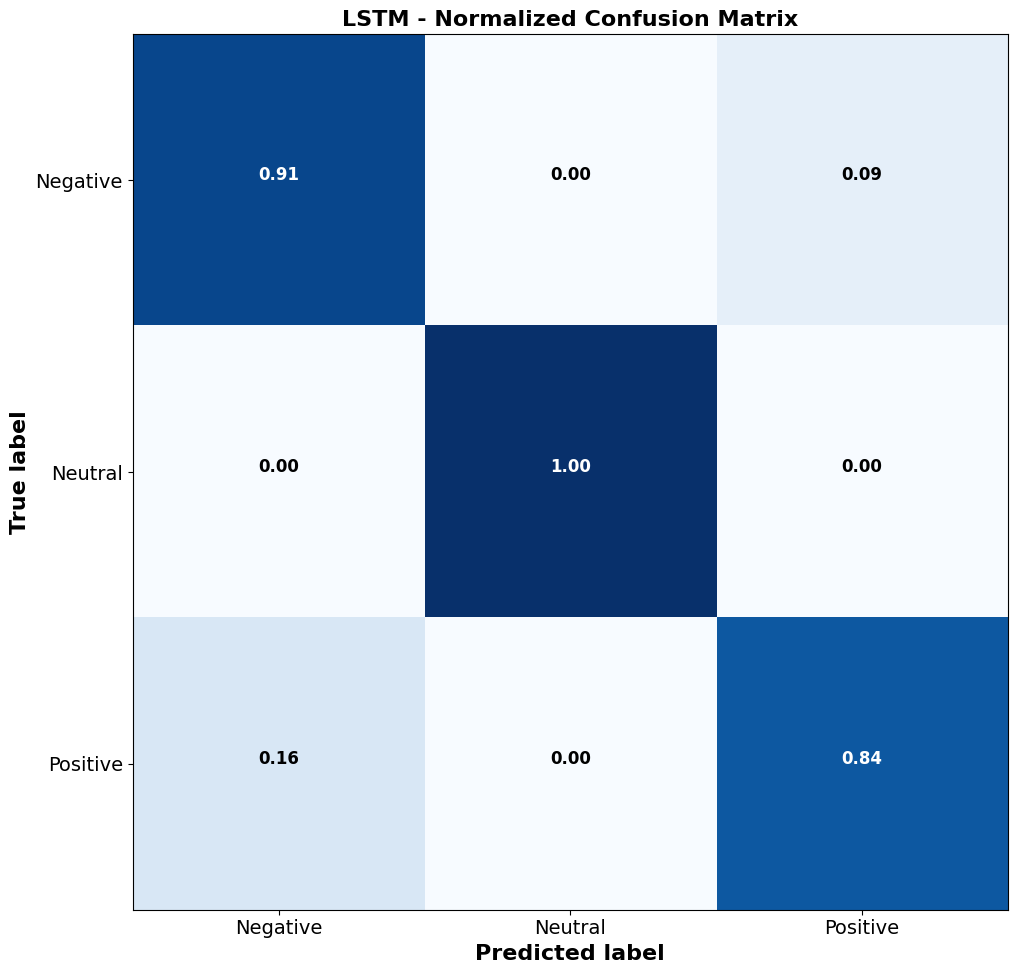

In [68]:

metrics_evolution(lstm_h, model_type='LSTM')
model_performances(model='./best_lstm_model.h5',x_test=x_test,y_test=y_test,model_type='LSTM',normalized_CM=True)

### **Model 2: GRU on fft subset**

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1500, 1)]         0         
                                                                 
 gru (GRU)                   (None, 1500, 256)         198912    
                                                                 
 gru_1 (GRU)                 (None, 1500, 256)         394752    
                                                                 
 gru_2 (GRU)                 (None, 1500, 256)         394752    
                                                                 
 dropout_14 (Dropout)        (None, 1500, 256)         0         
                                                                 
 dense_16 (Dense)            (None, 1500, 128)         32896     
                                                                 
 dropout_15 (Dropout)        (None, 1500, 128)         0   

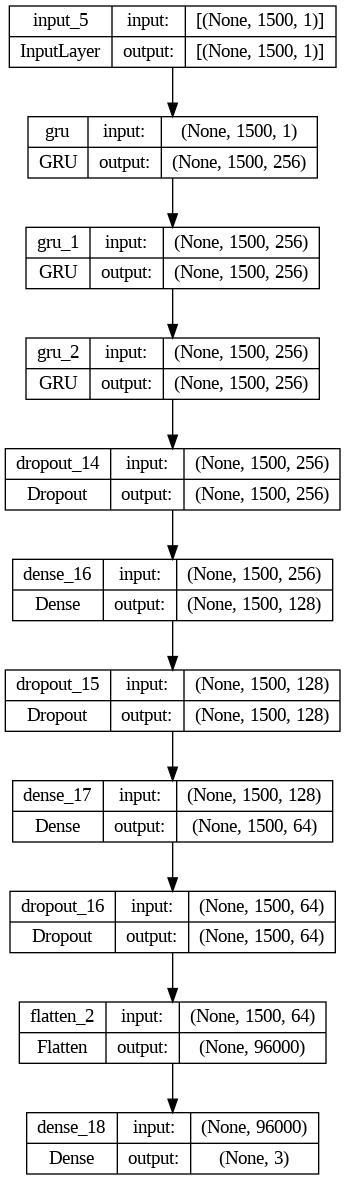

In [69]:
gru_model = rnn_model(
    x_train=X_train,
    n_classes=3,
    n_recurrent_neurons=256,
    model_type='gru'
)
print(gru_model.summary())
keras.utils.plot_model(gru_model, "gru.png", show_shapes=True)

In [70]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_gru_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

gru_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

print('fft signal modeling throught GRU')
gru_h = gru_model.fit(X_train, Y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[es, mc, lr_schedule])

fft signal modeling throught GRU
Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.0222 - accuracy: 0.7383
Epoch 1: val_accuracy improved from -inf to 0.90323, saving model to ./best_gru_model.h5
43/43 [==============================] - 18s 293ms/step - loss: 1.0222 - accuracy: 0.7383 - val_loss: 0.3414 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.8915
Epoch 2: val_accuracy did not improve from 0.90323
43/43 [==============================] - 10s 233ms/step - loss: 0.2906 - accuracy: 0.8915 - val_loss: 0.3389 - val_accuracy: 0.8094 - lr: 9.0484e-04
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.8886
Epoch 3: val_accuracy improved from 0.90323 to 0.93255, saving model to ./best_gru_model.h5
43/43 [==============================] - 11s 251ms/step - loss: 0.2720 - accuracy: 0.8886 - val_loss: 0.1955 - val_accuracy: 0.9326 - lr: 8.1873e-04
Epoch 4/50

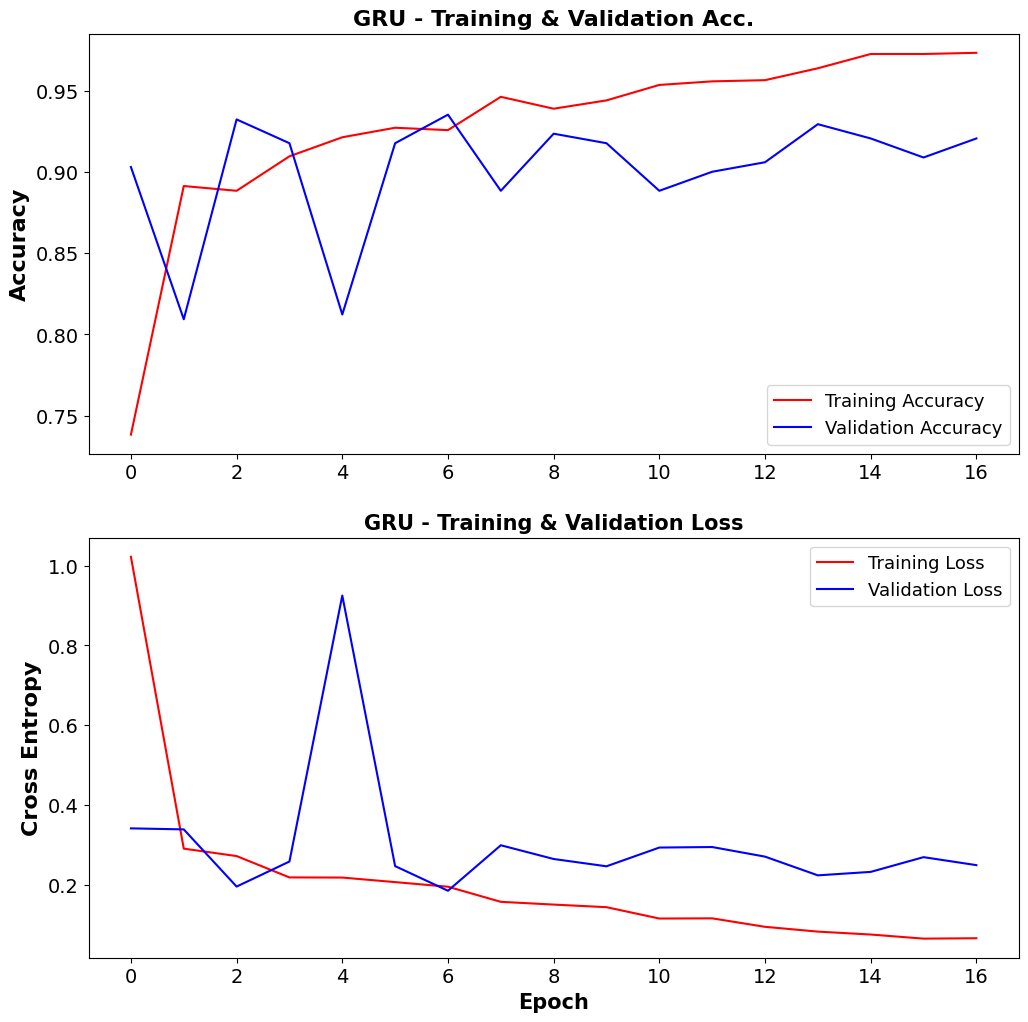

------------------------------------------------------------------
Model performances of model GRU saved as ./best_gru_model.h5:

Test Acc.: 90.867%

14/14 [==============================] - 2s 88ms/step
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       115
           1       0.99      1.00      0.99       164
           2       0.97      0.76      0.85       148

    accuracy                           0.91       427
   macro avg       0.91      0.91      0.90       427
weighted avg       0.92      0.91      0.91       427

Normalized confusion matrix


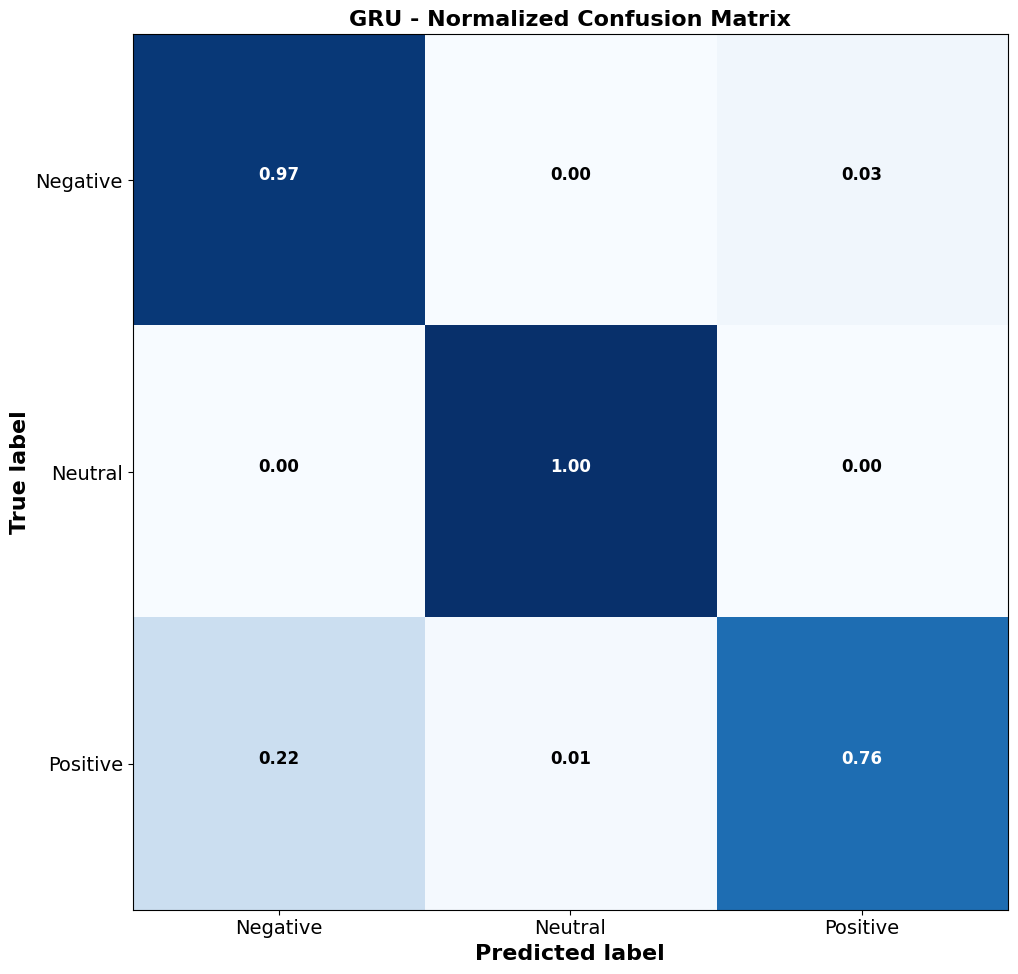

In [71]:
metrics_evolution(gru_h, model_type='GRU')
model_performances(model='./best_gru_model.h5',x_test=x_test,y_test=y_test,model_type='GRU',normalized_CM=True)

## **3.2 Variables subset**

Here DNN with a standard architeputure is used to model these data


In [72]:
X_train,Y_train,x_test,y_test,x_val,y_val=dataset_builder(X,Y,all_dataset=False,only_fft=False,show=False)


Only time indipendent columns are used 



In [73]:
def dnn_model(x_train,n_classes,dense_layers):
  input_layer=keras.layers.Input(shape=(x_train.shape[1], ))

  x = keras.layers.Masking(mask_value=-1)(input_layer)

  for n in dense_layers:
    x = keras.layers.Dense(n,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

  y = keras.layers.Dense(n_classes, activation='softmax')(x)

  return keras.models.Model(inputs=input_layer, outputs=y)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1048)]            0         
                                                                 
 masking_2 (Masking)         (None, 1048)              0         
                                                                 
 dense_19 (Dense)            (None, 128)               134272    
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                           

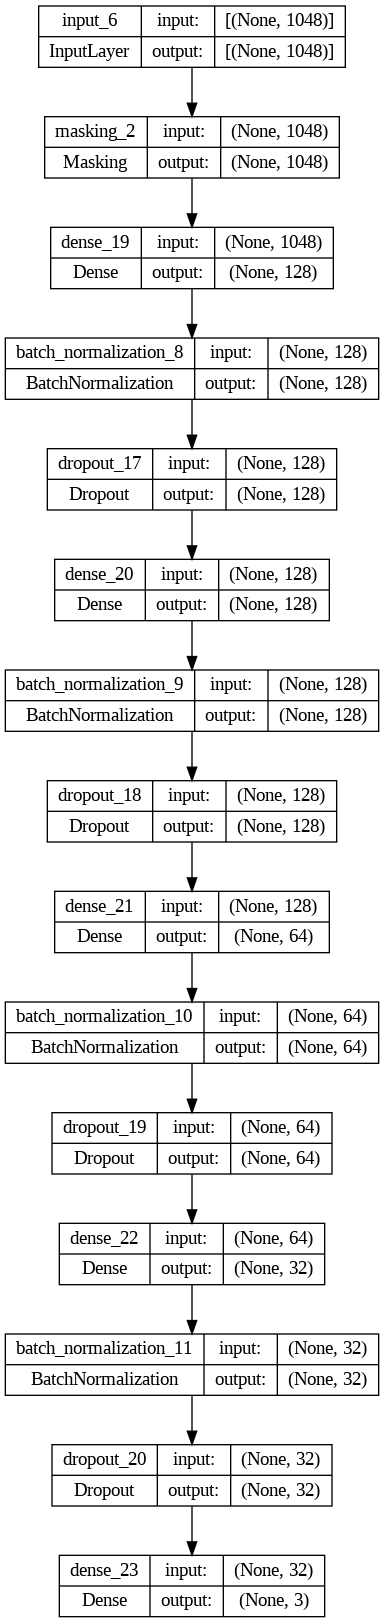

In [74]:
dnn_model = dnn_model(
    x_train=X_train,
    n_classes=3,
    dense_layers=[128,128,64,32]
)
print(dnn_model.summary())
keras.utils.plot_model(dnn_model, "dnn_1.png", show_shapes=True)

In [75]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True,min_delta=0.01)
mc = ModelCheckpoint('./best_dnn_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

dnn_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])


print('Variables modelling throught dnn')
dnn_h = dnn_model.fit(X_train, Y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[ es,mc, lr_schedule])

Variables modelling throught dnn
Epoch 1/50
42/43 [============================>.] - ETA: 0s - loss: 0.7968 - accuracy: 0.6905
Epoch 1: val_accuracy improved from -inf to 0.88270, saving model to ./best_dnn_model.h5
43/43 [==============================] - 4s 18ms/step - loss: 0.7950 - accuracy: 0.6928 - val_loss: 0.3972 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8776
Epoch 2: val_accuracy improved from 0.88270 to 0.92375, saving model to ./best_dnn_model.h5
43/43 [==============================] - 0s 10ms/step - loss: 0.3769 - accuracy: 0.8776 - val_loss: 0.2893 - val_accuracy: 0.9238 - lr: 9.0484e-04
Epoch 3/50
36/43 [========================>.....] - ETA: 0s - loss: 0.3222 - accuracy: 0.8906
Epoch 3: val_accuracy did not improve from 0.92375
43/43 [==============================] - 0s 8ms/step - loss: 0.3053 - accuracy: 0.8937 - val_loss: 0.2319 - val_accuracy: 0.9150 - lr: 8.1873e-04
Epoch 4/50
37/43 

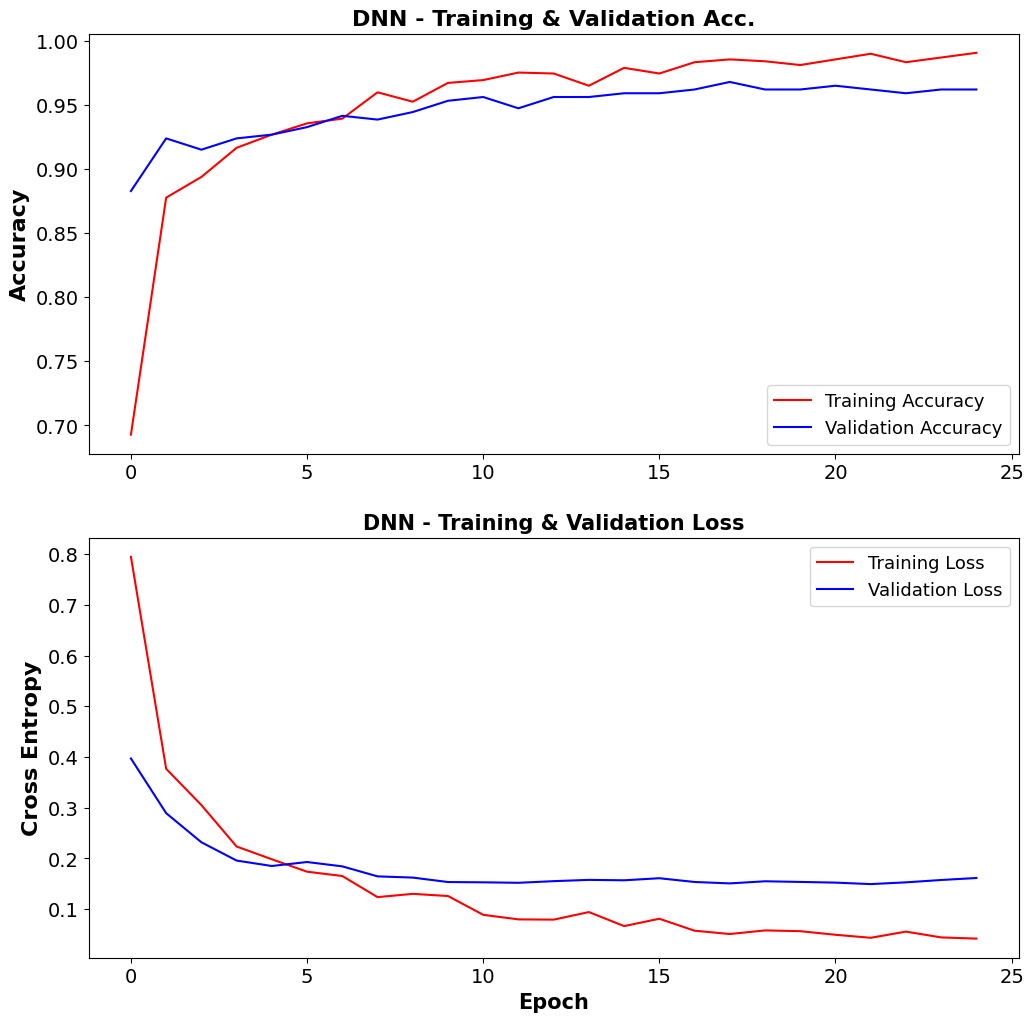

------------------------------------------------------------------
Model performances of model DNN saved as ./best_dnn_model.h5:

Test Acc.: 95.082%

14/14 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       115
           1       0.96      0.99      0.98       164
           2       0.97      0.89      0.93       148

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427

Normalized confusion matrix


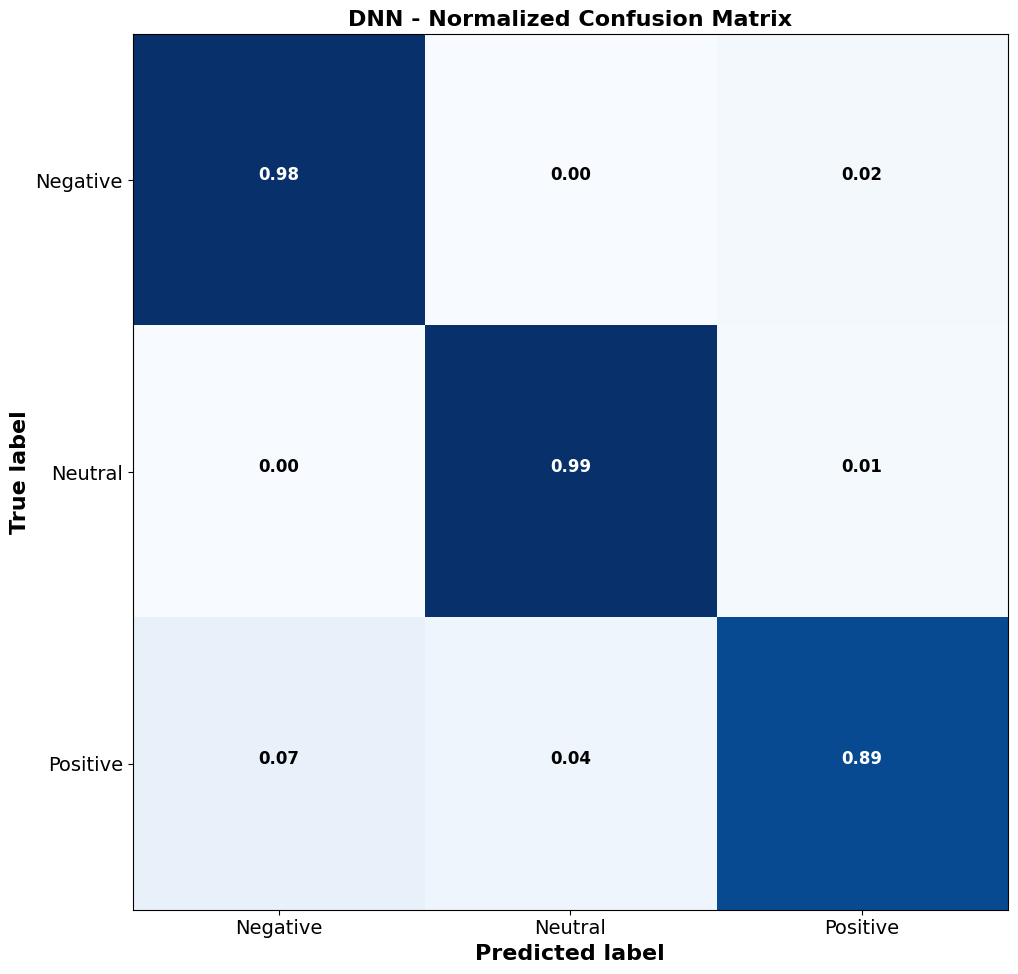

In [76]:

metrics_evolution(dnn_h, model_type='DNN')
model_performances(model='./best_dnn_model.h5',x_test=x_test,y_test=y_test,model_type='DNN',normalized_CM=True)

##**3.3 Whole dataset**
Here I use a DNN to model all the dataset. In this case using a LSTM framework doesn't have much sense, it's better proceeding with a standard net.


In [77]:
X_train,Y_train,x_test,y_test,x_val,y_val=dataset_builder(X,Y,all_dataset=True,only_fft=False,show=False)


Whole dataset will be used, option a) choosen 



In [78]:
def dnn_model(x_train,n_classes,dense_layers):
  input_layer=keras.layers.Input(shape=(x_train.shape[1], ))

  x = keras.layers.Masking(mask_value=-1)(input_layer)

  for n in dense_layers:
    x = keras.layers.Dense(n,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

  y = keras.layers.Dense(n_classes, activation='softmax')(x)

  return keras.models.Model(inputs=input_layer, outputs=y)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2548)]            0         
                                                                 
 masking_3 (Masking)         (None, 2548)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               652544    
                                                                 
 batch_normalization_12 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                           

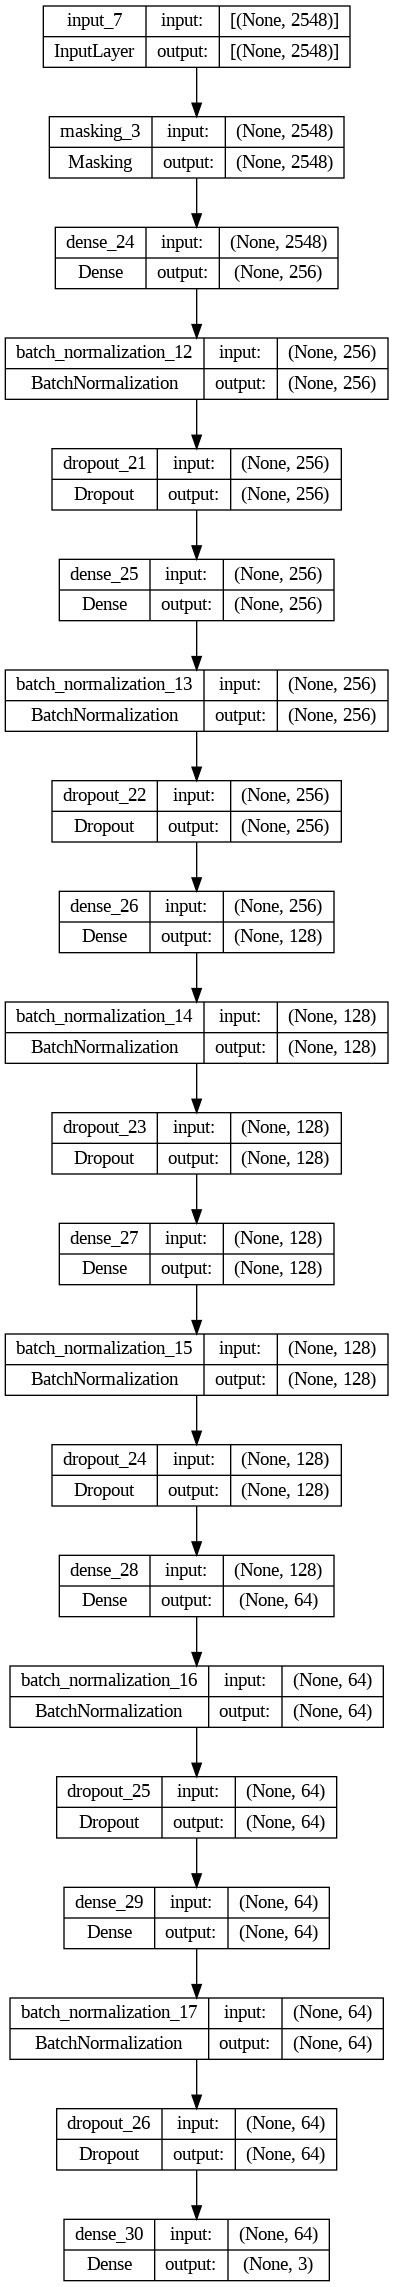

In [79]:
dnn_model_whole = dnn_model(
    x_train=X_train,
    n_classes=3,
    dense_layers=[256,256,128,128,64,64]
)
print(dnn_model_whole.summary())
keras.utils.plot_model(dnn_model_whole, "dnn_2.png", show_shapes=True)

In [80]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True,min_delta=0.01)
mc = ModelCheckpoint('./best_dnn_whole_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

dnn_model_whole.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

print('Variables modelling throught dnn')
dnn_whole_h = dnn_model_whole.fit(X_train, Y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[ es,mc, lr_schedule])

Variables modelling throught dnn
Epoch 1/50
41/43 [===========================>..] - ETA: 0s - loss: 0.9534 - accuracy: 0.6174
Epoch 1: val_accuracy improved from -inf to 0.72141, saving model to ./best_dnn_whole_model.h5
43/43 [==============================] - 7s 43ms/step - loss: 0.9356 - accuracy: 0.6232 - val_loss: 0.7685 - val_accuracy: 0.7214 - lr: 0.0010
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.8343
Epoch 2: val_accuracy improved from 0.72141 to 0.83578, saving model to ./best_dnn_whole_model.h5
43/43 [==============================] - 1s 13ms/step - loss: 0.4793 - accuracy: 0.8343 - val_loss: 0.4513 - val_accuracy: 0.8358 - lr: 9.0484e-04
Epoch 3/50
42/43 [============================>.] - ETA: 0s - loss: 0.3567 - accuracy: 0.8862
Epoch 3: val_accuracy improved from 0.83578 to 0.88856, saving model to ./best_dnn_whole_model.h5
43/43 [==============================] - 1s 13ms/step - loss: 0.3565 - accuracy: 0.8856 - val_loss: 0.28

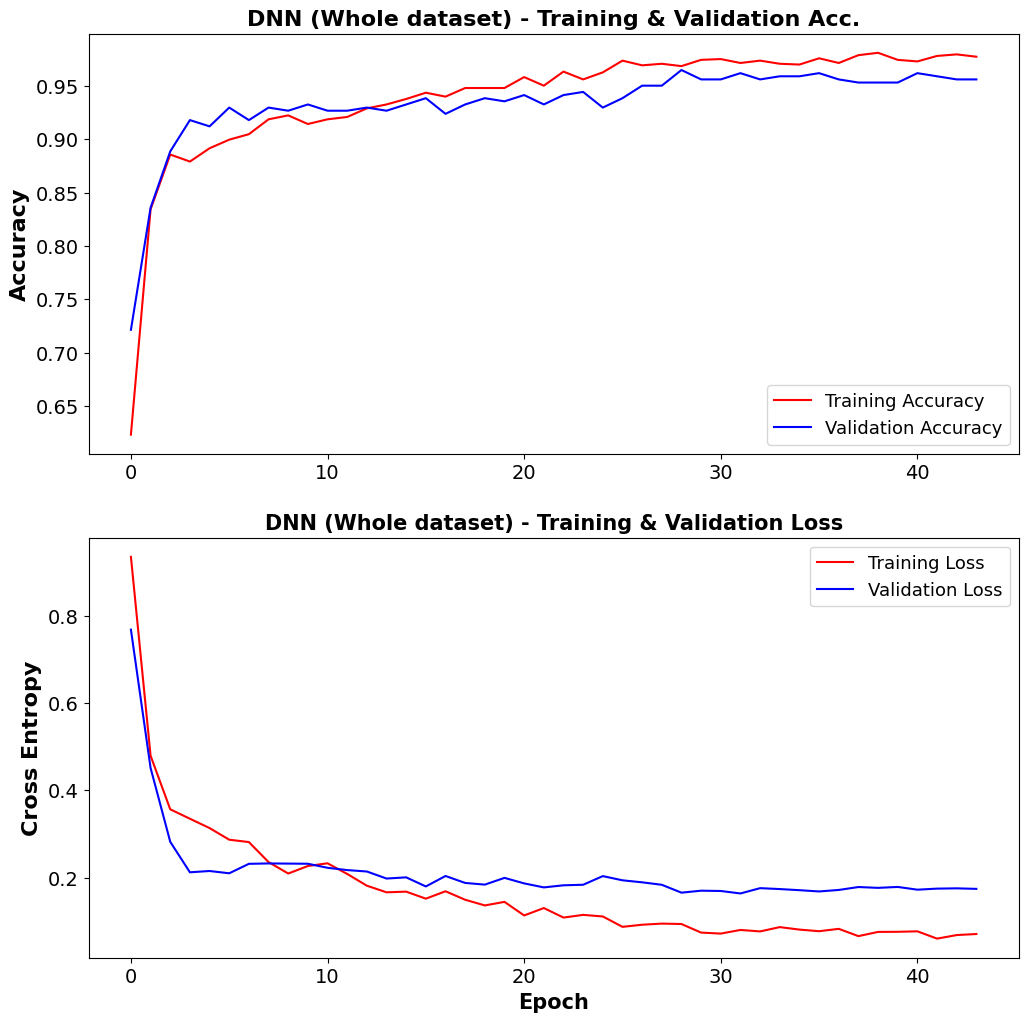

------------------------------------------------------------------
Model performances of model DNN (Whole dataset) saved as ./best_dnn_whole_model.h5:

Test Acc.: 97.190%

14/14 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       115
           1       0.98      0.98      0.98       164
           2       0.98      0.94      0.96       148

    accuracy                           0.97       427
   macro avg       0.97      0.97      0.97       427
weighted avg       0.97      0.97      0.97       427

Normalized confusion matrix


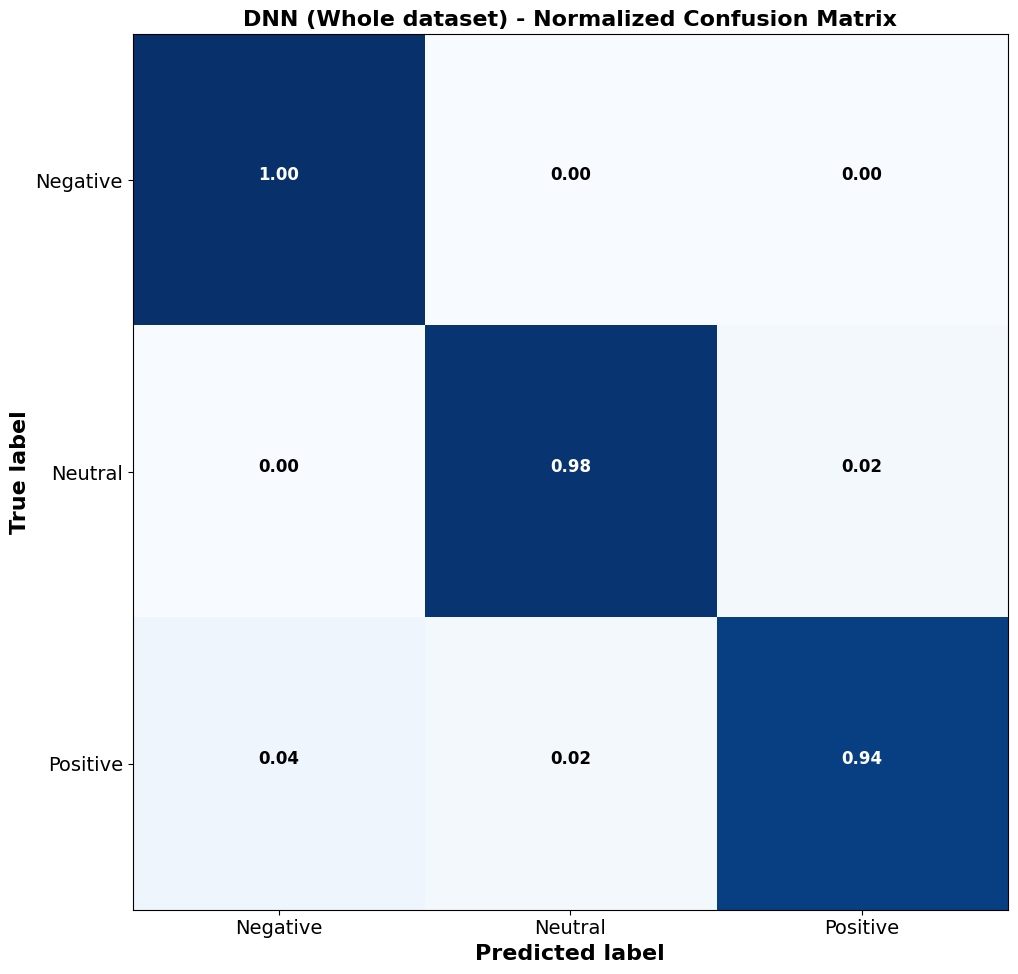

In [81]:

metrics_evolution(dnn_whole_h, model_type='DNN (Whole dataset)')
model_performances(model='./best_dnn_whole_model.h5',x_test=x_test,y_test=y_test,model_type='DNN (Whole dataset)',normalized_CM=True)

#**4-Conclusions on the first stage**

*Some comments about modelization*
1. **Dataset: fft signals, Model: LSTM**: Using only fft signals results are good. Accuracy is about 92% with a good performance on predicting neutral and negative classes, less on positive.
2. **Dataset: fft signal, Model: GRU**: results in prediction of neutral and negative are very good, despite that class positive isn't still well predicted. Possible overfitting phenomena (training stops before happens).
3. **Dataset: variables, Model: DNN**: huge improvements and good results in terms of classification performances. The model works well both from accuracy point of view and generalization capability point of view.
4. **Dateset: whole, Model: DNN**: Massive accuracy and overall performances. Model with most epochs used to train.



In conclusion, even if from a performance point of view using DNNs on variables or on the whole dataset, I'll proceed with using only the fft signal. This is due to the following reasons:
1. Stronger adherence on time series signals hypotesis
2. Usage of informations that can be easily processed and obtained.


#**5-Studing differences between group A and B**
The goal here is, once defined a new splitted dataset, finding possible differences between group A and group B in the dataset. In other words, are the model parameters different between these two groups even if the outcome is the same?

To find out if so, the following pipeline is followed:
1. Splitting the fft (sub)dataset in group A and B
2. Splitting A in train and validation sets. Training the model and avaluating the goodness of results. Possible changes in the model are allowed here.
3. Testing the model on B: if the results are good, probably the model trained on A will be the sae as the one trained on B, suggesting only less relevant differences between datasets.



## **5.1 Building subsets**


In [82]:
Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

In [83]:
# fft subset
fft_columns=X.columns[X.columns.str.contains('fft')]
X_fft=X[fft_columns]

# subset a and b
a_columns=X_fft.columns[X_fft.columns.str.contains('a')]
X_fft_a=X_fft[a_columns]

b_columns=X_fft.columns[X_fft.columns.str.contains('b')]
X_fft_b=X_fft[b_columns]

X_fft_a.head()


fft_0_a  fft_1_a  fft_2_a  fft_3_a  fft_4_a  fft_5_a  fft_6_a  fft_7_a  \
0   -520.0   398.00   -201.0   -201.0   398.00    -52.2   121.00    -64.0   
1     66.2    -4.30     43.6     43.6    -4.30     66.0   -29.00     73.3   
2    -90.8   204.00    -77.1    -77.1   204.00   -488.0   415.00   -187.0   
3    119.0     6.25     10.9     10.9     6.25   -333.0   283.00   -144.0   
4     59.0    -2.37     10.8     10.8    -2.37    118.0    -1.81     26.7   

   fft_8_a  fft_9_a  ...  fft_740_a  fft_741_a  fft_742_a  fft_743_a  \
0    -64.0   121.00  ...      179.0       26.4      -12.9      -12.9   
1     73.3   -29.00  ...      184.0       17.0      -18.9      -18.9   
2   -187.0   415.00  ...     -796.0      631.0     -261.0     -261.0   
3   -144.0   283.00  ...     -474.0      439.0     -221.0     -221.0   
4     26.7    -1.81  ...       30.7       50.3     -111.0     -111.0   

   fft_744_a  fft_745_a  fft_746_a  fft_747_a  fft_748_a  fft_749_a  
0       26.4    -474.00      442.0    -222.00    -222.00      442.0  
1       17.0     189.00      -19.6      -8.37      -8.37      -19.6  
2      631.0     -86.40      176.0    -100.00    -100.00      176.0  
3      439.0     272.00      -87.7      32.40      32.40      -87.7  
4       50.3      -2.43       30.5    -152.00    -152.00       30.5  

[5 rows x 750 columns]

In [84]:
X_fft_b.head()

fft_0_b  fft_1_b  fft_2_b  fft_3_b  fft_4_b  fft_5_b  fft_6_b  fft_7_b  \
0   -508.0   438.00  -222.00  -222.00   438.00    143.0    59.40     5.05   
1    126.0    -4.00     7.42     7.42    -4.00     81.6   -22.30    35.30   
2    -85.9   361.00   -62.20   -62.20   361.00   -558.0   684.00  -152.00   
3     69.5     3.89    12.10    12.10     3.89   -188.0   274.00  -200.00   
4    226.0   -27.40   147.00   147.00   -27.40    301.0    -8.48   138.00   

   fft_8_b  fft_9_b  ...  fft_740_b  fft_741_b  fft_742_b  fft_743_b  \
0     5.05    59.40  ...       74.3       23.5       20.3       20.3   
1    35.30   -22.30  ...      130.0      -23.3      -21.8      -21.8   
2  -152.00   684.00  ...     -534.0      462.0     -233.0     -233.0   
3  -200.00   274.00  ...     -183.0      299.0     -243.0     -243.0   
4   138.00    -8.48  ...      114.0       12.0       38.1       38.1   

   fft_744_b  fft_745_b  fft_746_b  fft_747_b  fft_748_b  fft_749_b  
0       23.5     -215.0     280.00    -162.00    -162.00     280.00  
1      -23.3      182.0       2.57     -31.60     -31.60       2.57  
2      462.0     -267.0     281.00    -148.00    -148.00     281.00  
3      299.0      132.0     -12.40       9.53       9.53     -12.40  
4       12.0      119.0     -17.60      23.90      23.90     -17.60  

[5 rows x 750 columns]

In [85]:
# splitting train and validation
X_train, x_val, Y_train, y_val = train_test_split(X_fft_a,Y,random_state=111, test_size=0.2)

In [86]:
X_train.head()

fft_0_a  fft_1_a  fft_2_a  fft_3_a  fft_4_a  fft_5_a  fft_6_a  fft_7_a  \
1404   -142.0    185.0   -79.60   -79.60    185.0    -43.3     96.0   -19.40   
83       37.4     36.2   -26.80   -26.80     36.2    125.0     46.6   -66.40   
1318    144.0     11.4     4.06     4.06     11.4    -23.8    116.0  -107.00   
384     152.0     34.6   -34.30   -34.30     34.6     69.4     20.1     7.95   
1538    118.0    -12.3   -40.10   -40.10    -12.3     44.2    -34.6    19.40   

      fft_8_a  fft_9_a  ...  fft_740_a  fft_741_a  fft_742_a  fft_743_a  \
1404   -19.40     96.0  ...       93.9      32.70     -31.60     -31.60   
83     -66.40     46.6  ...       48.2      19.70     -33.10     -33.10   
1318  -107.00    116.0  ...     -165.0     185.00     -83.20     -83.20   
384      7.95     20.1  ...       69.9     -11.80       6.24       6.24   
1538    19.40    -34.6  ...      220.0       9.27     -41.30     -41.30   

      fft_744_a  fft_745_a  fft_746_a  fft_747_a  fft_748_a  fft_749_a  
1404      32.70     -475.0    349.000     -237.0     -237.0    349.000  
83        19.70       61.5     -0.897     -131.0     -131.0     -0.897  
1318     185.00     -335.0    368.000     -164.0     -164.0    368.000  
384      -11.80      -16.5    -14.500      -18.5      -18.5    -14.500  
1538       9.27      203.0     -9.700      -19.5      -19.5     -9.700  

[5 rows x 750 columns]

In [87]:
Y_train.head()

1404    0
83      2
1318    0
384     2
1538    1
Name: label, dtype: int64

In [88]:
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
x_test = np.array(X_fft_b).reshape((X_fft_b.shape[0], X_fft_b.shape[1],1))

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(Y)
y_val = pd.get_dummies(y_val)

## **5.2 - Model training on subset a**

In [89]:
def rnn_model(x_train,n_classes,n_recurrent_neurons,model_type='lstm'):
  input_layer = keras.layers.Input(shape=(x_train.shape[1], 1))

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(input_layer)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(input_layer)

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(x)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(x)

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(x)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(x)

  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Flatten()(x)
  y = keras.layers.Dense(n_classes, activation='softmax')(x)

  return keras.models.Model(inputs=input_layer, outputs=y)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 750, 1)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 750, 256)          264192    
                                                                 
 lstm_7 (LSTM)               (None, 750, 256)          525312    
                                                                 
 lstm_8 (LSTM)               (None, 750, 256)          525312    
                                                                 
 dropout_27 (Dropout)        (None, 750, 256)          0         
                                                                 
 dense_31 (Dense)            (None, 750, 128)          32896     
                                                                 
 dropout_28 (Dropout)        (None, 750, 128)          0   

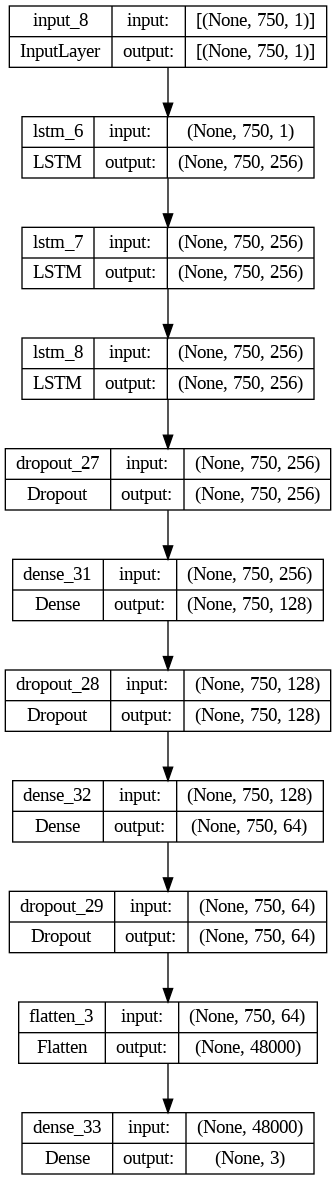

In [90]:
lstm_model_a = rnn_model(
    x_train=X_train,
    n_classes=3,
    n_recurrent_neurons=256,
    model_type='lstm'
)
print(lstm_model_a.summary())
keras.utils.plot_model(lstm_model_a, "lstm_subset_a.png", show_shapes=True)

In [91]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True,min_delta=0.01)
mc = ModelCheckpoint('./best_lstm_a_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

lstm_model_a.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

print('fft signal modeling throught LSTM')
lstm_a_h = lstm_model_a.fit(X_train, Y_train,
                  batch_size=32,
                  validation_data=(x_val, y_val),
                  epochs=50,
                  callbacks=[ es,mc, lr_schedule])

fft signal modeling throught LSTM
Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.4267 - accuracy: 0.8217
Epoch 1: val_accuracy improved from -inf to 0.88056, saving model to ./best_lstm_a_model.h5
54/54 [==============================] - 17s 178ms/step - loss: 0.4267 - accuracy: 0.8217 - val_loss: 0.3034 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.8962
Epoch 2: val_accuracy improved from 0.88056 to 0.88290, saving model to ./best_lstm_a_model.h5
54/54 [==============================] - 9s 162ms/step - loss: 0.2677 - accuracy: 0.8962 - val_loss: 0.2509 - val_accuracy: 0.8829 - lr: 9.0484e-04
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9097
Epoch 3: val_accuracy improved from 0.88290 to 0.90164, saving model to ./best_lstm_a_model.h5
54/54 [==============================] - 8s 144ms/step - loss: 0.2384 - accuracy: 0.9097 - val_loss: 0.2224 -

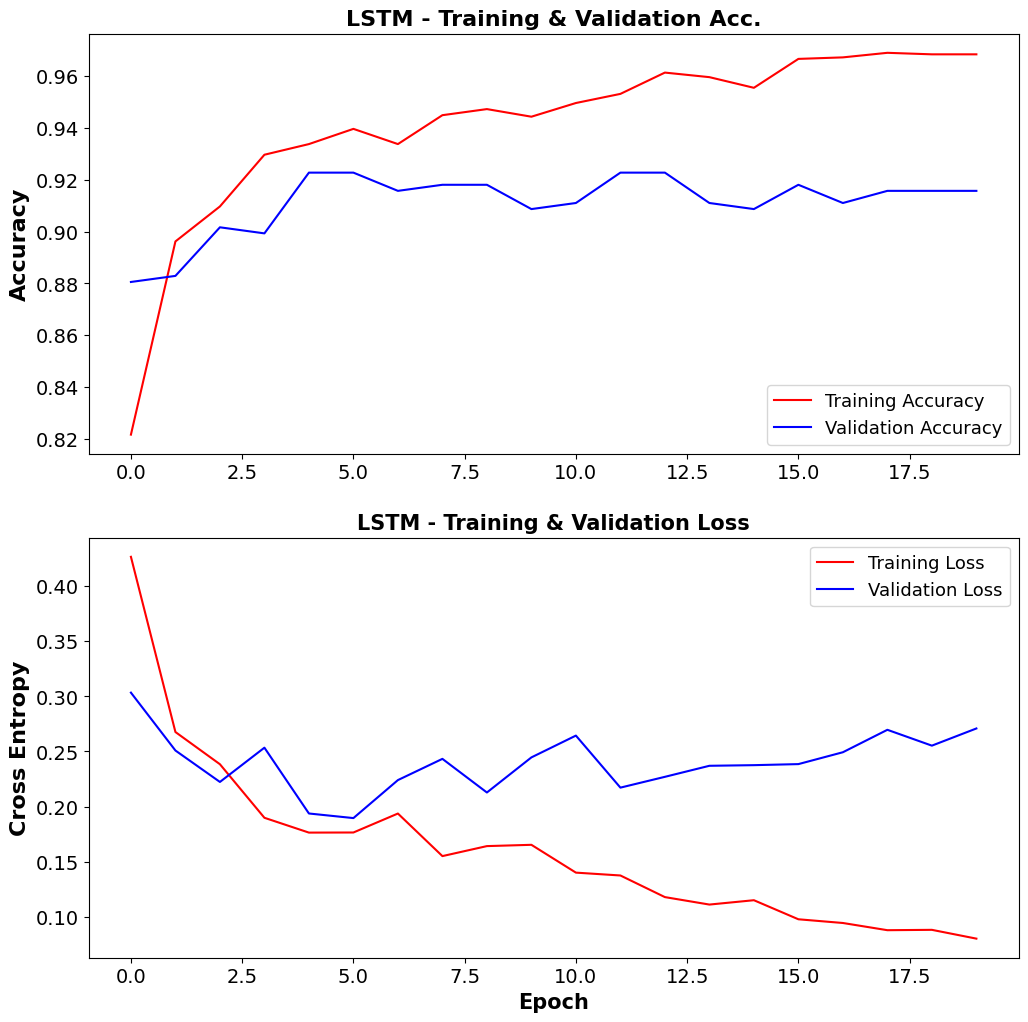

------------------------------------------------------------------
Model performances of model LSTM saved as ./best_lstm_a_model.h5:

Test Acc.: 93.949%

67/67 [==============================] - 5s 64ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       708
           1       1.00      1.00      1.00       716
           2       0.95      0.86      0.90       708

    accuracy                           0.94      2132
   macro avg       0.94      0.94      0.94      2132
weighted avg       0.94      0.94      0.94      2132

Normalized confusion matrix


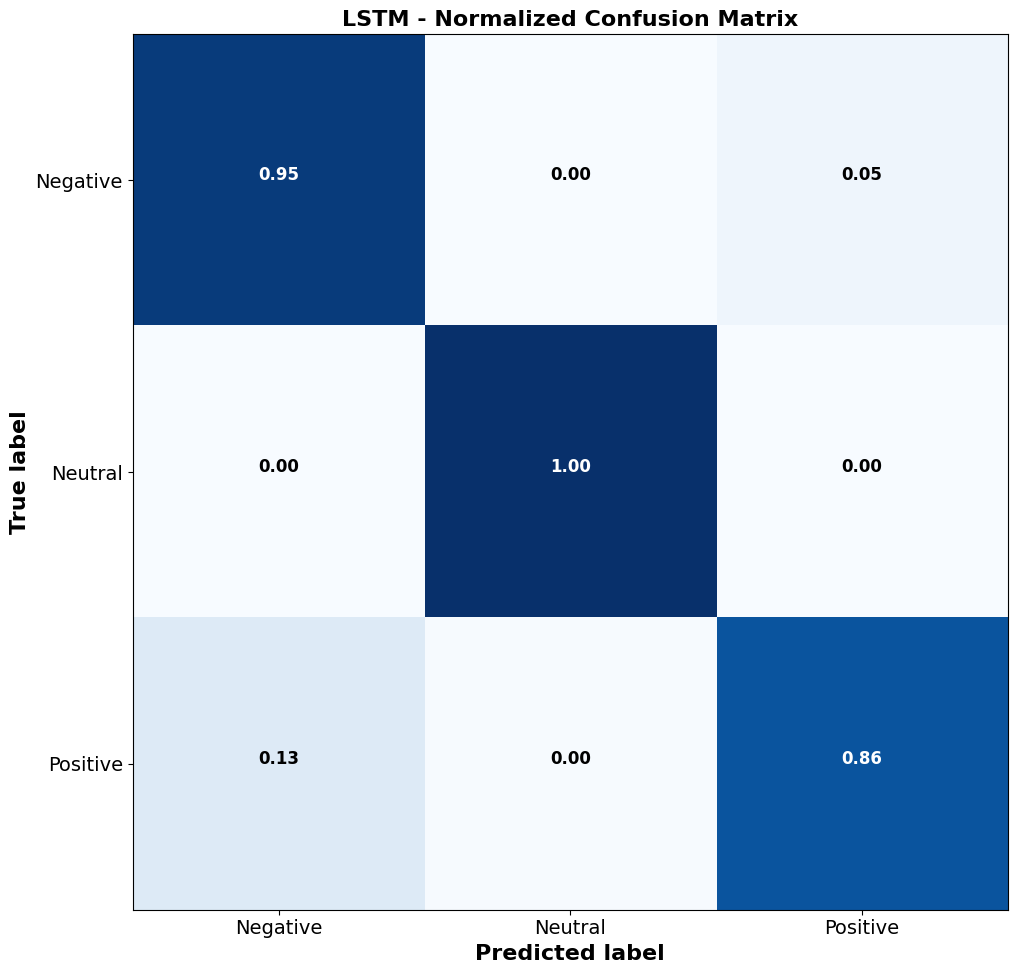

In [92]:

metrics_evolution(lstm_a_h, model_type='LSTM')
model_performances(model='./best_lstm_a_model.h5',x_test=x_test,y_test=y_test,model_type='LSTM',normalized_CM=True)

# **6- Conclusions**

Finally we can draw some conclusions. Firsly it has been shown that the LSTM network can model in a good way the fft signal, threating both signals as two following ones. Moreover, in this scenario DNN trained on tempo-independent features performes even better, suggesting that in a simple classification task these features are more relevat, as even shown by the cross-entropy analysis.

1. **Dataset: fft signals, Model: LSTM**: Accuracy 92% (choosen for the second part)
2. **Dataset: fft signal, Model: GRU**: Accuracy 90%
3. **Dataset: variables, Model: DNN**: Accuracy 95%
4. **Dateset: whole, Model: DNN**: Accuracy 97%

Then the second part of the analysis shows that using subject A to predict subject B lead to good results, with an accuracy of 93%, suggesting that both fft series are similar for the same label and thus there aren't much differences between subjects (at least in this dataset).

